# Challenge Set 1: MTA Turnstile Data



Helper fx() to read NYC MTA data into the file and import plotting library:

In [1]:
#Supress warnings
import warnings
warnings.simplefilter("ignore")

In [2]:
import pandas as pd
import datetime as dt
import itertools 

pd.set_option('display.float_format', lambda x: '%.0f' % x)


def get_mta_data(number_of_weeks):
    n = number_of_weeks
    j = 0; d = 0 #interators
    df = pd.DataFrame() #empyt df
    l = [] #empty list
    cols = ['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME', 'DESC', 'ENTRIES', 'EXITS']
    while j < n:
        days_back = dt.date(2016, 9, 17) - dt.timedelta(days=d)
        link = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_' + days_back.strftime('%y%m%d') + '.txt'
        data = pd.read_csv(link, sep=",", engine='python', index_col=None, header=None, skiprows=1)
        l.append(data)
        df = pd.concat(l)
        d = d + 7
        j = j + 1
    df.columns = cols
    df['DATE_TIME'] = pd.to_datetime(df.DATE +' '+df.TIME, infer_datetime_format=True) #CREATE DATE TIME FEATURE
    df = df.sort_values(["C/A", "UNIT", "SCP", "STATION","DATE","TIME"])
    return df

# Exercise 1.1

- Open up a new Jupyter notebook
- Download a few MTA turnstile data files
- Open up a file, use csv reader to read it, make a python dict where
  there is a key for each (C/A, UNIT, SCP, STATION). These are the
  first four columns. The value for this key should be a list of
  lists. Each list in the list is the rest of the columns in a
  row. For example, one key-value pair should look like


In [3]:
df = get_mta_data(4)  #load the last 3 weeks of MTA data starting from (2016, 9, 17)
df.head(5)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
0,A002,R051,02-00-00,59 ST,NQR456,BMT,08/20/2016,00:00:00,REGULAR,5790246,1963095,2016-08-20 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456,BMT,08/20/2016,04:00:00,REGULAR,5790275,1963101,2016-08-20 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456,BMT,08/20/2016,08:00:00,REGULAR,5790284,1963123,2016-08-20 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456,BMT,08/20/2016,12:00:00,REGULAR,5790377,1963178,2016-08-20 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456,BMT,08/20/2016,16:00:00,REGULAR,5790605,1963230,2016-08-20 16:00:00


# Exercise 1.2

- Let's turn this into a time series.

- Let the list be comprised of just the point in time and the count of entries.

In [4]:
new_df = df[["C/A", "UNIT", "SCP", "STATION", "DATE","DATE_TIME","ENTRIES"]]
new_df.head(3)

#new_df['DATE'] = pd.DatetimeIndex(new_df.DATE_TIME).normalize() #create date feature from datetime 
#new_df.drop(['DATE_TIME'],axis=1)
scp_dict = new_df.set_index(["C/A","STATION", "UNIT", "SCP", "DATE"]).T.to_dict(orient='list')

print dict(itertools.islice(scp_dict.iteritems(), 5)) #print 5 entries from dict

{('N506', '34 ST-HERALD SQ', 'R022', '00-05-05', '08/23/2016'): [Timestamp('2016-08-23 20:00:00'), 6192832], ('N317', '46 ST', 'R267', '02-00-02', '09/04/2016'): [Timestamp('2016-09-04 21:00:00'), 521112], ('R238A', 'GRD CNTRL-42 ST', 'R046', '02-03-01', '08/26/2016'): [Timestamp('2016-08-26 20:00:00'), 26], ('R316', 'INTERVALE AV', 'R407', '00-00-01', '09/14/2016'): [Timestamp('2016-09-14 21:00:00'), 4191072], ('R258', '125 ST', 'R132', '00-03-01', '08/26/2016'): [Timestamp('2016-08-26 21:00:00'), 5651356]}


# Exercise 1.3

- We want total daily entries.
- Now make it that we again have the same keys, but now we have a single value for a single day
- The total number of passengers that entered through this turnstile on this day.

In [7]:
#max_hr captures the max hr for the date and the max entries
#subtract this max from the previous day to get a ~ 24 total
#drop the min date + 1 to start timeseries on Monday

max_hr = new_df.groupby(["C/A","STATION", "UNIT", "SCP", "DATE"])[["ENTRIES",'DATE_TIME']].max().reset_index()
max_hr['entries_diff'] = max_hr.ENTRIES.diff()
max_hr = max_hr.drop('ENTRIES',axis=1)
max_hr = max_hr[max_hr['DATE']>'08/21/2016']
max_hr['entries_diff'][max_hr['entries_diff'] < 0] = 0
max_hr['entries_diff'][max_hr['entries_diff'] > 200000] = 0

df2 = max_hr.set_index(["C/A","STATION", "UNIT", "SCP"])


#convert to dictionary format
mtaDict = {}
for x in range(len(df2)):
    currentid = df2.index[x]
    currentvalue = df2.iloc[x,0]
    currentvalue1 = df2.iloc[x,2]
    mtaDict.setdefault(currentid, [])
    mtaDict[currentid].append([currentvalue,currentvalue1])

print dict(itertools.islice(mtaDict.iteritems(), 1)) #print 3 entries from dict

{('B031', 'BRIGHTON BEACH', 'R172', '01-00-00'): [['08/22/2016', 797.0], ['08/23/2016', 756.0], ['08/24/2016', 809.0], ['08/25/2016', 734.0], ['08/26/2016', 750.0], ['08/27/2016', 606.0], ['08/28/2016', 567.0], ['08/29/2016', 799.0], ['08/30/2016', 822.0], ['08/31/2016', 741.0], ['09/01/2016', 765.0], ['09/02/2016', 823.0], ['09/03/2016', 481.0], ['09/04/2016', 437.0], ['09/05/2016', 423.0], ['09/06/2016', 744.0], ['09/07/2016', 837.0], ['09/08/2016', 943.0], ['09/09/2016', 919.0], ['09/10/2016', 562.0], ['09/11/2016', 479.0], ['09/12/2016', 807.0], ['09/13/2016', 964.0], ['09/14/2016', 915.0], ['09/15/2016', 1011.0], ['09/16/2016', 883.0]]}


# Exercise 1.4


- Plot the daily time series for a single turnstile.


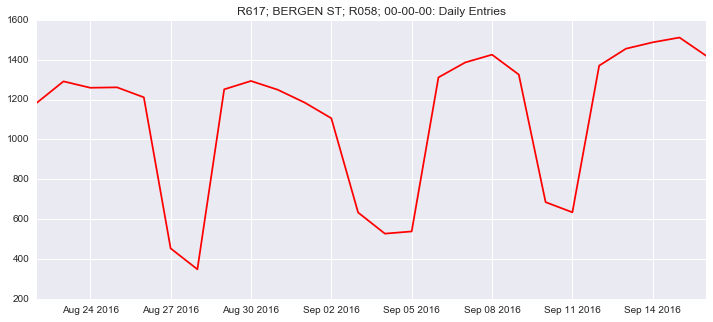

In [8]:
#Magic function to plot in notebook
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn


#extract our data to two list 
data = zip(*mtaDict[('R617', 'BERGEN ST', 'R058', '00-00-00')]) #key for turnstile we will rank
date_list = list(data[0])
counts = list(data[1])

dates = [dt.datetime.strptime(date, '%m/%d/%Y').date() for date in date_list]


plt.figure(figsize=(12,5))
plt.title('R617; BERGEN ST; R058; 00-00-00: Daily Entries')
plt.plot(dates,counts, 'r',);




# Exercise 1.5

- Combine turnstiles in the same ControlArea/Unit/Station combo. 
- There are some ControlArea/Unit/Station groups that have a single turnstile
- Most have multiple turnstilea same value for the C/A, UNIT and STATION columns,different values for the SCP column.
- We want to combine the numbers together for each ControlArea/UNIT/STATION combo, for each day, add the counts from each turnstile belonging to that combo.

In [9]:
station_df = max_hr.groupby(['C/A','UNIT','STATION','DATE'])['entries_diff'].sum()
station_df.head(19)

C/A   UNIT  STATION  DATE      
A002  R051  59 ST    08/22/2016   15188
                     08/23/2016   16724
                     08/24/2016   16741
                     08/25/2016   16815
                     08/26/2016   16494
                     08/27/2016    9917
                     08/28/2016    7896
                     08/29/2016   15462
                     08/30/2016   16622
                     08/31/2016   16557
                     09/01/2016   16464
                     09/02/2016   15919
                     09/03/2016    9336
                     09/04/2016    7303
                     09/05/2016    7105
                     09/06/2016   15694
                     09/07/2016   17425
                     09/08/2016   18063
                     09/09/2016   17826
Name: entries_diff, dtype: float64

# Exercise 1.6



Similarly, combine everything in each station, and come up with a time series of [(date1, count1),(date2,count2),...] type of time series for each STATION, by adding up all the turnstiles in a station.


In [10]:
stations = max_hr.groupby(['STATION','DATE'])['entries_diff'].sum().reset_index()

df3 = stations.set_index(["STATION"])

mtaStationDict = {}
for x in range(len(df3)):
    currentid = df3.index[x]
    currentvalue = df3.iloc[x,0]
    currentvalue1 = df3.iloc[x,1]
    mtaStationDict.setdefault(currentid, [])
    mtaStationDict[currentid].append([currentvalue,currentvalue1])

print dict(itertools.islice(mtaDict.iteritems(), 1))

{('B031', 'BRIGHTON BEACH', 'R172', '01-00-00'): [['08/22/2016', 797.0], ['08/23/2016', 756.0], ['08/24/2016', 809.0], ['08/25/2016', 734.0], ['08/26/2016', 750.0], ['08/27/2016', 606.0], ['08/28/2016', 567.0], ['08/29/2016', 799.0], ['08/30/2016', 822.0], ['08/31/2016', 741.0], ['09/01/2016', 765.0], ['09/02/2016', 823.0], ['09/03/2016', 481.0], ['09/04/2016', 437.0], ['09/05/2016', 423.0], ['09/06/2016', 744.0], ['09/07/2016', 837.0], ['09/08/2016', 943.0], ['09/09/2016', 919.0], ['09/10/2016', 562.0], ['09/11/2016', 479.0], ['09/12/2016', 807.0], ['09/13/2016', 964.0], ['09/14/2016', 915.0], ['09/15/2016', 1011.0], ['09/16/2016', 883.0]]}


# Exercise 1.7

Plot the time series for a station.



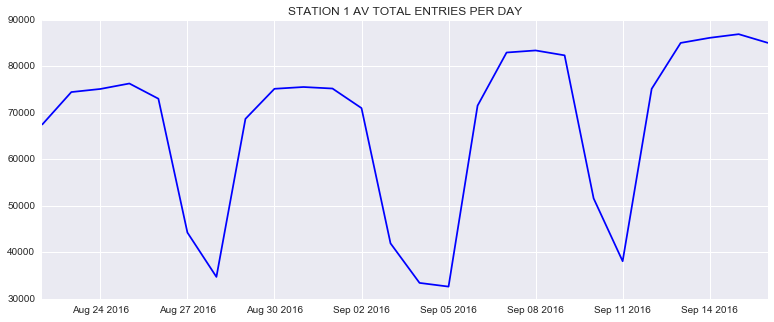

In [21]:
#extract our data into two list 

data = zip(*mtaStationDict[('59 ST')]) #key for station
date_list = list(data[0])
counts = list(data[1])
dates = [dt.datetime.strptime(date, '%m/%d/%Y').date() for date in date_list] #convert dates

#plot it up
plt.figure(figsize=(13,5))
plt.title('STATION 1 AV TOTAL ENTRIES PER DAY')
plt.plot(dates,counts, 'b',);

# Exercise 1.8


Make one list of counts for one week for one station. Monday's count, Tuesday's count, etc. so it's a list of 7 counts. Make the same list for another week, and another week, and another week. plt.plot(week_count_list) for every week_count_list you created this way. You should get a rainbow plot of weekly commute numbers on top of each other.

In [13]:
#create a week number and a week day feature for the 
max_hr.head()
station_by_week = max_hr.groupby(['STATION','DATE_TIME'])['entries_diff'].sum().reset_index()
station_by_week['Week_Number'] = station_by_week['DATE_TIME'].dt.week
station_by_week['Week_day'] = station_by_week['DATE_TIME'].dt.weekday
station_by_week = station_by_week.sort(['STATION','Week_Number','Week_day']).set_index(['STATION','Week_Number'])
station_by_week.head(10)

DATE_TIME  entries_diff  Week_day
STATION Week_Number                                            
1 AV    34          2016-08-22 20:00:00         17265         0
        34          2016-08-23 20:00:00         19371         1
        34          2016-08-24 20:00:00         19848         2
        34          2016-08-25 20:00:00         20118         3
        34          2016-08-26 20:00:00         20120         4
        34          2016-08-27 20:00:00         16964         5
        34          2016-08-28 20:00:00         13871         6
        35          2016-08-29 20:00:00         18064         0
        35          2016-08-30 20:00:00         19182         1
        35          2016-08-31 20:00:00         19616         2

In [14]:
station_by_week=station_by_week.reset_index()

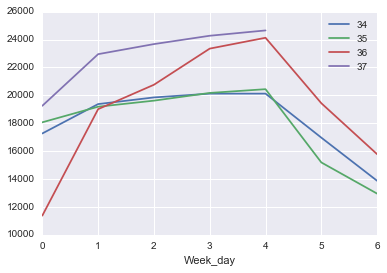

In [23]:
fig, ax = plt.subplots(1, 1)
# station_sample_group = station_by_week[station_by_week['STATION']==['1 AV'].groupby(["Week_Number"])
station_sample_group = station_by_week[station_by_week.STATION == '1 AV'].groupby(['Week_Number'])
                                       
# station_sample_group = station_by_week[station_by_week['STATION']==['1 AV'].groupby(["Week_Number"])
for key, grp in station_sample_group:
    grp.plot("Week_day", "entries_diff", ax=ax, label=key)


# Exercise 1.9




Over multiple weeks, sum total ridership for each station and sort them, so you can find out the stations with the highest traffic during the time you investigate

In [16]:
station_total = station_by_week.reset_index().groupby(['STATION'])['entries_diff'].sum().reset_index()
station_total = station_total.sort('entries_diff', ascending = [0])
print "Top 10 Stations for Entry Volume: (8/29/2016 - 9/16/2016)"
station_total.head(10).set_index('STATION')

Top 10 Stations for Entry Volume: (8/29/2016 - 9/16/2016)


,entries_diff
STATION,
34 ST-PENN STA,3757294
GRD CNTRL-42 ST,3260971
34 ST-HERALD SQ,2633379
23 ST,2548403
14 ST-UNION SQ,2374915
86 ST,2322816
TIMES SQ-42 ST,2194709
FULTON ST,2126421
42 ST-PORT AUTH,2102229


# Exercise 1.10



Make a single list of these total ridership values and plot it.


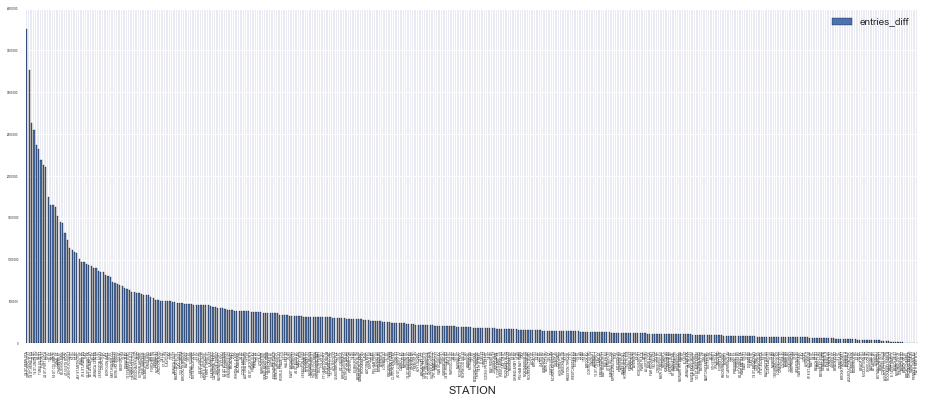

In [17]:
station_total.set_index('STATION').plot(kind='bar',figsize=(16,6),fontsize=3);